In [1]:
from utils.query_model import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
import sys
import re

In [2]:
df = pd.read_csv('../data/guland_hanoi_listings_arcgis3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16581 entries, 0 to 16580
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 16581 non-null  object 
 1   Price                 16581 non-null  float64
 2   Area                  16581 non-null  float64
 3   Address               16581 non-null  object 
 4   Description           14859 non-null  object 
 5   Link                  16581 non-null  object 
 6   Latitude              16581 non-null  float64
 7   Longitude             16581 non-null  float64
 8   Price per m2          16581 non-null  float64
 9   distance_from_center  16581 non-null  float64
 10  bin_x                 16581 non-null  int64  
 11  bin_y                 16581 non-null  int64  
 12  Area_Range            16581 non-null  object 
dtypes: float64(6), int64(2), object(5)
memory usage: 1.6+ MB


In [4]:
df.isna().sum()

Title                      0
Price                      0
Area                       0
Address                    0
Description             1722
Link                       0
Latitude                   0
Longitude                  0
Price per m2               0
distance_from_center       0
bin_x                      0
bin_y                      0
Area_Range                 0
dtype: int64

In [5]:
t, p, a, d, lat, lon, pm2, nl = "Title", "Price", "Area", "Description", "Latitude", "Longitude", "Price per m2", "\n"

def create_general_info(df):
    # Convert Description NaNs to empty string
    description = df[d].fillna("Không có mô tả").astype(str)
    
    # prince_info = "Giá nhà: " + (df[p]/1000000).astype(str) + "tỷ" + nl
    area_info = "Diện tích: " + df[a].astype(str) + "m2" + nl
    # lat_info = "Vĩ độ: " + df[lat].astype(str) + nl
    # lon_info = "Kinh độ: " + df[lon].astype(str) + nl
    # pm2_info = "Giá/m2: " + (df[pm2]).astype(str) + " triệu" + nl

    return df[t] + nl + description + nl + area_info #+  prince_info + lat_info + lon_info + pm2_info

In [6]:
model = "Qwen/Qwen2.5-0.5B-Instruct"
device = "auto"
max_new_tokens = 5
# batch_inference = True
# batch_size = 20
temperature = 1.0
top_p = 1.0
length_df = df.shape[0]
max_retries = 3

In [7]:
sys_prompt = """Bạn là chuyên gia phân tích bất động sản Việt Nam. 
Nhiệm vụ của bạn là xác định số phòng ngủ từ mô tả bất động sản.

Quy trình phân tích:
1. Tìm các cụm từ chính xác như: " A phòng ngủ", "APN", "A PN", "A Phòng Ngủ", "A PHÒNG NGỦ"
2. Nếu thấy nhiều con số khác nhau, ưu tiên số được ghi kèm với "phòng ngủ" hoặc "PN"
3. Nếu không tìm thấy thông tin rõ ràng, KHÔNG đưa ra giả định

VÍ DỤ:
"Nhà có 3 phòng ngủ rộng rãi" → 3
"Căn hộ 2PN" → 2
"Nhà 4 phòng (2 phòng ngủ, 1 phòng khách)" → 2
"Diện tích 80m2" → KHÔNG đủ thông tin để xác định -> 0

LƯU Ý QUAN TRỌNG:
- Hạn chế trả lời số 0, cố gắng suy đoán thông tin về phòng ngủ
- CHỈ trả lời MỘT chữ số từ 0-9
- KHÔNG giải thích hoặc thêm từ nào khác
"""

In [8]:
df_new = pd.DataFrame()
df_new['general_info'] = create_general_info(df)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16581 entries, 0 to 16580
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   general_info  16581 non-null  object
dtypes: object(1)
memory usage: 129.7+ KB


In [9]:
df_new.head()

,general_info
0,🌟 Cơ hội đầu tư – Tòa apartment 7 tầng tại Xuâ...
1,Siêu phẩm bán nhà mặt phố cầu giấy6 tầng thang...
2,"Bán nhà mặt phố đường bưởi, quận ba đình, 26m2..."
3,Cần mua bán ki ốt 52m2 tại Chung Cư HH Linh Đà...
4,Bán nhà 27m² 14 tỷ tại Mặt phố Thái Thịnh Phườ...


In [10]:
df_new['category'] = -1
df_new['retry_count'] = 0

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16581 entries, 0 to 16580
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   general_info  16581 non-null  object
 1   category      16581 non-null  int64 
 2   retry_count   16581 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 388.7+ KB


In [ ]:
interface = ModelQueryInterface()
interface.load_model(model_name=model, device_map=device)

def check_valid_room_number_response(response):
    # Clean response more thoroughly
    response = response.strip().lower()
    # First check for exact single digit
    if re.search(r'^[1-9]$', response):
        return int(response)
    # Second try to extract first digit
    match = re.search(r'[1-9]', response)
    if match:
        return int(match.group(0))
    return None

total_processed = 0
total_errors = 0
error_rate = 0.0

for i in range(max_retries):
    progress_bar = tqdm(range(length_df), desc=f"Retry {i+1}/{max_retries} | Error rate: {error_rate:.2f}%")
    for idx in progress_bar:
        if df_new.loc[idx, 'category'] == -1:
            prompt = f"{sys_prompt}\nThông tin bất động sản:\n{df_new.loc[idx, 'general_info']}\nSố phòng ngủ ước lượng là:"

            response = interface.query_model(prompt, max_new_tokens=max_new_tokens, temperature=temperature, top_p=top_p)
            room_number = check_valid_room_number_response(response)
            # print(f"Index: {idx}, Parsed: {room_number}")
            
            total_processed += 1
            
            if room_number is not None:
                df_new.loc[idx, 'category'] = room_number
            else:
                df_new.loc[idx, 'retry_count'] = df_new.loc[idx, 'retry_count'] + 1
                total_errors += 1
            
            error_rate = (total_errors / total_processed) * 100
            
            if idx % 10 == 0:
                progress_bar.set_description(f"Retry {i+1}/{max_retries} | Error rate: {error_rate:.2f}%")

Loading model: Qwen/Qwen2.5-0.5B-Instruct
This may take a few minutes for the first time...
Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading model...


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ Model loaded successfully!
Model device: mps:0


Retry 1/3 | Error rate: 0.00%:   0%|          | 0/16581 [00:00<?, ?it/s]

<Axes: ylabel='Frequency'>

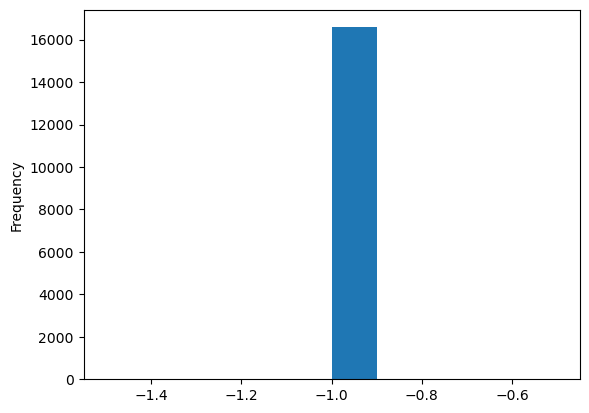

In [ ]:
df_new['category'].plot(kind = 'hist')

In [ ]:
df.to_csv('../data/guland_hanoi_listings_with_bedrooms_arcgis4.csv', index=False)